In [1]:
!mkdir %userprofile%\.kaggle
!copy kaggle.json %userprofile%\.kaggle\

A subdirectory or file C:\Users\001\.kaggle already exists.


        1 file(s) copied.


In [ ]:
!kaggle datasets download -d dmitrybabko/speech-emotion-recognition-en

https://www.kaggle.com/code/shivamburnwal/speech-emotion-recognition/notebook

https://github.com/nicknochnack/DeepAudioClassification/blob/main/AudioClassification.ipynb

# Imports

In [311]:
import pandas as pd
import numpy as np

import os
import sys

import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from IPython.display import Audio

import tensorflow as tf
import tensorflow_io as tfio
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization, Conv2D,MaxPooling2D
from tensorflow.keras.metrics import Precision, Recall, Accuracy

In [2]:
pd.set_option('display.max_columns', None)
pd.options.display.max_colwidth = 200

In [3]:
Ravdess = "./speech-emotion-recognition-en/Ravdess/audio_speech_actors_01-24/"
Crema = "./speech-emotion-recognition-en/Crema/"
Tess = "./speech-emotion-recognition-en/Tess/"
Savee = "./speech-emotion-recognition-en/Savee/"

# Ravdess Dataset

In [6]:
file_paths_ravdess = []
file_emotions_ravdess = []
actors = os.listdir(Ravdess)
for actor in actors:
    files = os.listdir(Ravdess+actor)
    for file in files:
        file_part = file.split('.')
        file_part_2 = file_part[0].split('-')
        emotion = int(file_part_2[2])
        file_emotions_ravdess.append(emotion)
        file_paths_ravdess.append(Ravdess+actor+'/'+file)
ravdess_df = pd.DataFrame(zip(file_emotions_ravdess,file_paths_ravdess),columns=['Emotions','Paths'])
ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
ravdess_df.head()

,Emotions,Paths
0,neutral,./speech-emotion-recognition-en/Ravdess/audio_speech_actors_01-24/Actor_01/03-01-01-01-01-01-01.wav
1,neutral,./speech-emotion-recognition-en/Ravdess/audio_speech_actors_01-24/Actor_01/03-01-01-01-01-02-01.wav
2,neutral,./speech-emotion-recognition-en/Ravdess/audio_speech_actors_01-24/Actor_01/03-01-01-01-02-01-01.wav
3,neutral,./speech-emotion-recognition-en/Ravdess/audio_speech_actors_01-24/Actor_01/03-01-01-01-02-02-01.wav
4,calm,./speech-emotion-recognition-en/Ravdess/audio_speech_actors_01-24/Actor_01/03-01-02-01-01-01-01.wav


# Crema Dataset

In [7]:
files = os.listdir(Crema)
file_paths_crema = []
file_emotions_crema = []
for file in files:
    file_part = file.split('.')
    file_part_2 = file_part[0].split('_')
    emotion = file_part_2[2]
    if emotion == 'SAD':
        file_emotions_crema.append('sad')
    elif emotion == 'ANG':
        file_emotions_crema.append('angry')
    elif emotion == 'DIS':
        file_emotions_crema.append('disgust')
    elif emotion == 'FEA':
        file_emotions_crema.append('fear')
    elif emotion == 'HAP':
        file_emotions_crema.append('happy')
    elif emotion == 'NEU':
        file_emotions_crema.append('neutral')
    else:
        file_emotions_crema.append('Unknown')
    file_paths_crema.append(Crema+file)

crema_df = pd.DataFrame(zip(file_emotions_crema,file_paths_crema),columns=['Emotions','Paths'])
crema_df.head()

,Emotions,Paths
0,angry,./speech-emotion-recognition-en/Crema/1001_DFA_ANG_XX.wav
1,disgust,./speech-emotion-recognition-en/Crema/1001_DFA_DIS_XX.wav
2,fear,./speech-emotion-recognition-en/Crema/1001_DFA_FEA_XX.wav
3,happy,./speech-emotion-recognition-en/Crema/1001_DFA_HAP_XX.wav
4,neutral,./speech-emotion-recognition-en/Crema/1001_DFA_NEU_XX.wav


# Tess Dataset

In [8]:
file_paths_tess = []
file_emotions_tess = []
dirs = os.listdir(Tess)
for d in dirs:
    files = os.listdir(Tess+d)
    emotion_from_dir = d.split('_')[-1].lower()
    emotion_from_dir = 'surprise' if emotion_from_dir=='surprised' else emotion_from_dir # because there is a folder named YAF_pleasant_surprised
    file_emotions_tess+=[emotion_from_dir]*len(files)
    for file in files:
        file_paths_tess.append(Tess+d+'/'+file)
tess_df = pd.DataFrame(zip(file_emotions_tess,file_paths_tess),columns=['Emotions','Paths'])

In [9]:
tess_df.sample(10)

,Emotions,Paths
1243,sad,./speech-emotion-recognition-en/Tess/OAF_Sad/OAF_food_sad.wav
2159,happy,./speech-emotion-recognition-en/Tess/YAF_happy/YAF_sour_happy.wav
515,fear,./speech-emotion-recognition-en/Tess/OAF_Fear/OAF_pad_fear.wav
2318,neutral,./speech-emotion-recognition-en/Tess/YAF_neutral/YAF_pass_neutral.wav
1845,fear,./speech-emotion-recognition-en/Tess/YAF_fear/YAF_gas_fear.wav
2152,happy,./speech-emotion-recognition-en/Tess/YAF_happy/YAF_sheep_happy.wav
265,disgust,./speech-emotion-recognition-en/Tess/OAF_disgust/OAF_hush_disgust.wav
149,angry,./speech-emotion-recognition-en/Tess/OAF_angry/OAF_shack_angry.wav
464,fear,./speech-emotion-recognition-en/Tess/OAF_Fear/OAF_hurl_fear.wav
655,happy,./speech-emotion-recognition-en/Tess/OAF_happy/OAF_hall_happy.wav


# Savee Dataset

In [10]:
savee_directory_list = os.listdir(Savee)

file_emotions_savee = []
file_paths_savee = []

for file in savee_directory_list:
    file_paths_savee.append(Savee + file)
    part = file.split('_')[1]
    ele = part[:-6]
    if ele=='a':
        file_emotions_savee.append('angry')
    elif ele=='d':
        file_emotions_savee.append('disgust')
    elif ele=='f':
        file_emotions_savee.append('fear')
    elif ele=='h':
        file_emotions_savee.append('happy')
    elif ele=='n':
        file_emotions_savee.append('neutral')
    elif ele=='sa':
        file_emotions_savee.append('sad')
    else:
        file_emotions_savee.append('surprise')
        
savee_df = pd.DataFrame(zip(file_emotions_savee,file_paths_savee), columns=['Emotions','Paths'])

In [11]:
savee_df.sample(10)

,Emotions,Paths
445,neutral,./speech-emotion-recognition-en/Savee/KL_n26.wav
328,neutral,./speech-emotion-recognition-en/Savee/JK_n29.wav
409,happy,./speech-emotion-recognition-en/Savee/KL_h05.wav
436,neutral,./speech-emotion-recognition-en/Savee/KL_n17.wav
342,sad,./speech-emotion-recognition-en/Savee/JK_sa13.wav
135,disgust,./speech-emotion-recognition-en/Savee/JE_d01.wav
466,surprise,./speech-emotion-recognition-en/Savee/KL_su02.wav
46,happy,./speech-emotion-recognition-en/Savee/DC_h02.wav
319,neutral,./speech-emotion-recognition-en/Savee/JK_n20.wav
355,surprise,./speech-emotion-recognition-en/Savee/JK_su11.wav


# Concatenate whole dataframes

In [12]:
data_df = pd.concat([ravdess_df,crema_df,tess_df,savee_df],axis=0)

In [13]:
data_df.sample(10)

,Emotions,Paths
3493,neutral,./speech-emotion-recognition-en/Crema/1043_TIE_NEU_XX.wav
4403,angry,./speech-emotion-recognition-en/Crema/1054_WSI_ANG_XX.wav
7432,fear,./speech-emotion-recognition-en/Crema/1091_TSI_FEA_XX.wav
766,disgust,./speech-emotion-recognition-en/Crema/1010_IWL_DIS_XX.wav
1193,surprise,./speech-emotion-recognition-en/Ravdess/audio_speech_actors_01-24/Actor_20/03-01-08-01-01-02-20.wav
1407,neutral,./speech-emotion-recognition-en/Crema/1018_IOM_NEU_XX.wav
968,calm,./speech-emotion-recognition-en/Ravdess/audio_speech_actors_01-24/Actor_17/03-01-02-02-01-01-17.wav
466,disgust,./speech-emotion-recognition-en/Ravdess/audio_speech_actors_01-24/Actor_08/03-01-07-01-02-01-08.wav
462,fear,./speech-emotion-recognition-en/Tess/OAF_Fear/OAF_hole_fear.wav
1928,fear,./speech-emotion-recognition-en/Tess/YAF_fear/YAF_rag_fear.wav


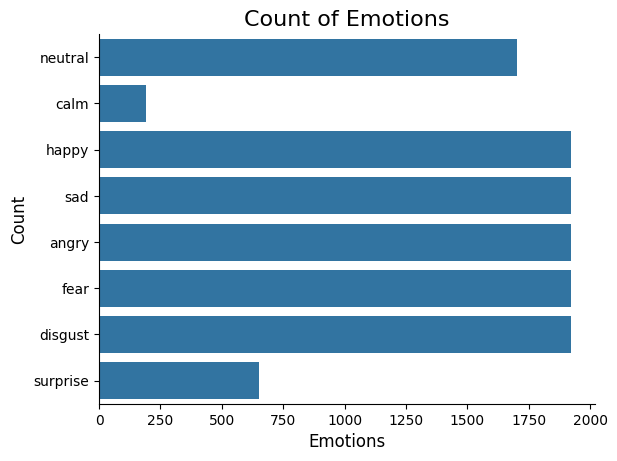

In [14]:
plt.title('Count of Emotions', size=16)
sns.countplot(data_df.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

# Try out some audio files

## Using Librosa

In [15]:
def get_random_sample():
    random_sample = data_df.iloc[np.random.randint(len(data_df))]
    return random_sample.Emotions, random_sample.Paths

In [16]:
temp_audio_emotion,temp_audio_path = get_random_sample()

In [17]:
temp_audio_emotion

'happy'

In [18]:
Audio(temp_audio_path)

In [19]:
raw_data, sample_rate = librosa.load(temp_audio_path)

In [20]:
raw_data, sample_rate

(array([ 5.4487269e-03,  6.3874968e-03,  5.8062985e-03, ...,
        -1.5709103e-09,  5.9781075e-10, -6.4672989e-12], dtype=float32),
 22050)

In [21]:
raw_data.shape

(62538,)

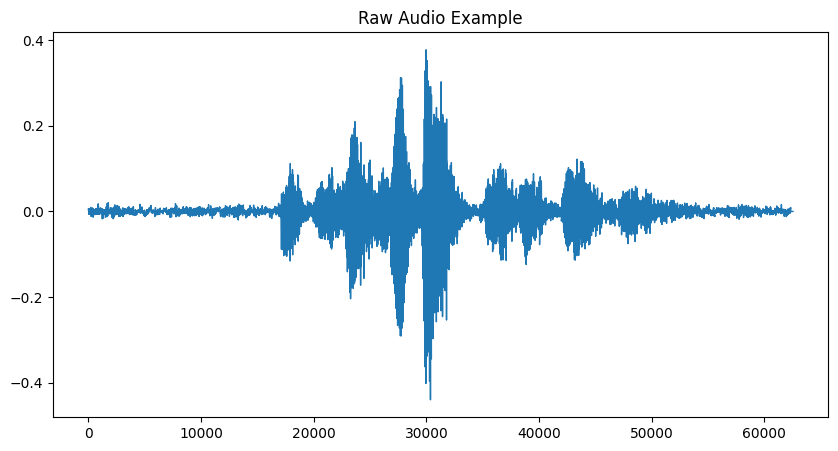

In [22]:
pd.Series(raw_data).plot(figsize=(10,5),lw=1,title='Raw Audio Example')
plt.show()

As you can notice there are alot of silence at the beginning and the end of the audio file.

In [23]:
raw_data_trimmed, index = librosa.effects.trim(raw_data,top_db=25)

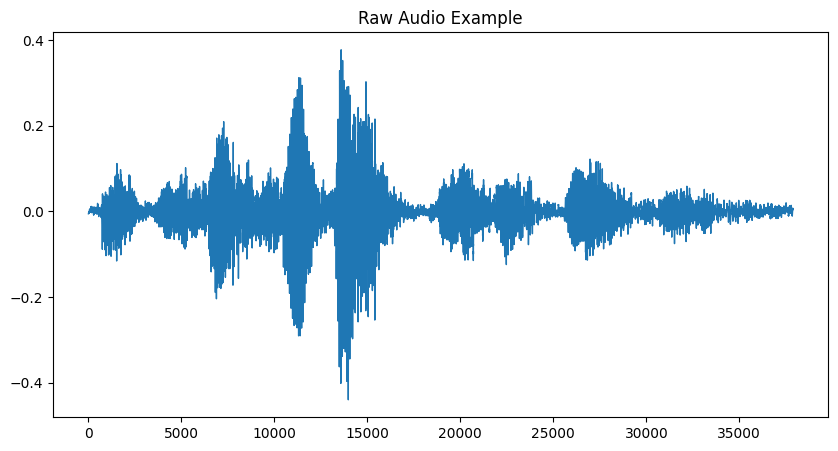

In [24]:
pd.Series(raw_data_trimmed).plot(figsize=(10,5),lw=1,title='Raw Audio Example')
plt.show()

In [97]:
def create_waveplot(data, e):
    pd.Series(raw_data).plot(figsize=(10,5),lw=1,title=f'{e} emotion')
    plt.show()

def create_spectrogram(data, sr, e=None, plot=True):
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    if plot:
        plt.figure(figsize=(12, 3))
        plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
        librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
        plt.colorbar()
    return Xdb

def create_mel_spectogram(data,sr,e=None, plot=True):
    S = librosa.feature.melspectrogram(y=data,sr=sr,n_mels=128 * 2)
    S_db_mel = librosa.amplitude_to_db(S, ref=np.max)
    if plot:
        fig, ax = plt.subplots(figsize=(10, 5))
        img = librosa.display.specshow(S_db_mel,x_axis='time',y_axis='log',ax=ax)
        ax.set_title('Mel Spectogram Example', fontsize=20)
        fig.colorbar(img, ax=ax, format=f'%0.2f')
        plt.show()
    return S_db_mel

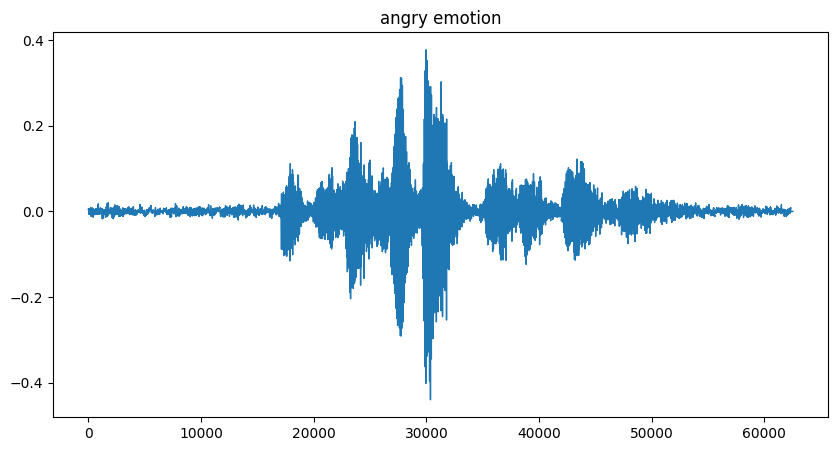

In [98]:
random_sample_emotion,random_sample_path = get_random_sample()
random_sample_data,random_sample_sr = librosa.load(random_sample_path, sr=32000) 
create_waveplot(random_sample_data,random_sample_emotion)

In [99]:
random_sample_data.shape,random_sample_sr

((83284,), 32000)

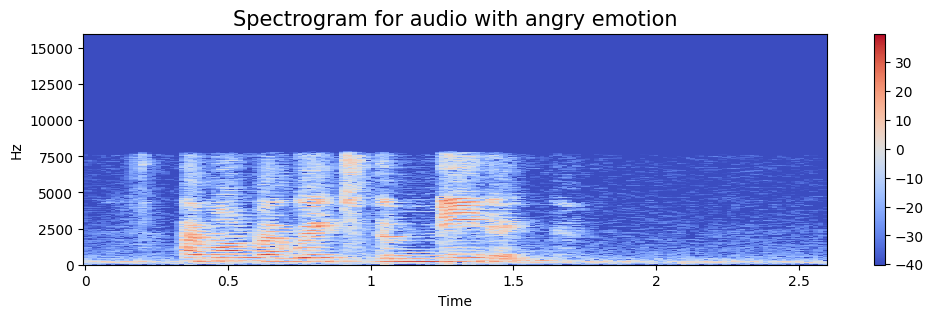

In [103]:
spectogram = create_spectrogram(random_sample_data, 32000, random_sample_emotion)

In [105]:
spectogram.shape

(1025, 163)

In [107]:
tf.expand_dims(spectogram, axis=2)

<tf.Tensor: shape=(1025, 163, 1), dtype=float32, numpy=
array([[[-11.129925],
        [-16.471327],
        [-32.00943 ],
        ...,
        [-40.14156 ],
        [-27.97926 ],
        [-21.20739 ]],

       [[-10.996003],
        [-13.401431],
        [-23.94784 ],
        ...,
        [-32.654263],
        [-32.463486],
        [-21.523304]],

       [[-11.175268],
        [-13.382393],
        [-32.225937],
        ...,
        [-30.925264],
        [-29.037077],
        [-22.642164]],

       ...,

       [[-40.14156 ],
        [-40.14156 ],
        [-40.14156 ],
        ...,
        [-40.14156 ],
        [-40.14156 ],
        [-40.14156 ]],

       [[-40.14156 ],
        [-40.14156 ],
        [-40.14156 ],
        ...,
        [-40.14156 ],
        [-40.14156 ],
        [-40.14156 ]],

       [[-40.14156 ],
        [-40.14156 ],
        [-40.14156 ],
        ...,
        [-40.14156 ],
        [-40.14156 ],
        [-40.14156 ]]], dtype=float32)>

In [101]:
Audio(random_sample_path)

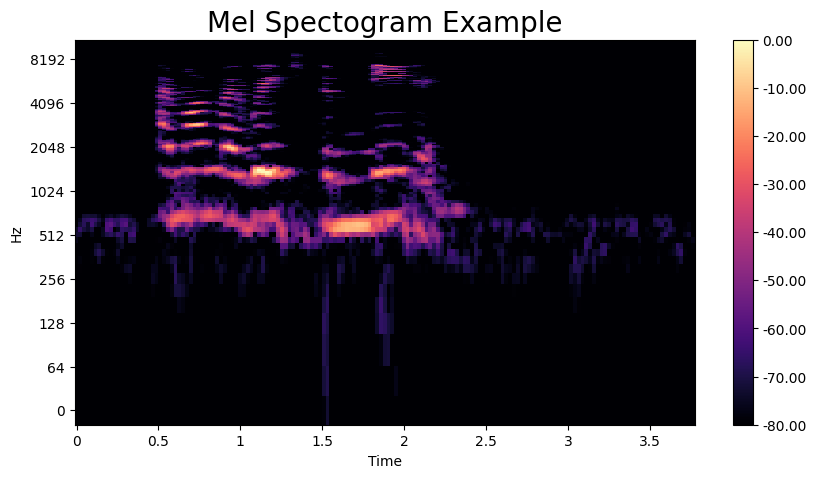

In [108]:
mel_spectogram=create_mel_spectogram(random_sample_data, 32000, random_sample_emotion)

In [109]:
mel_spectogram.shape

(256, 163)

In [56]:
lengths=[]
for row in data_df.iterrows():
    data,sr = librosa.load(row[1]['Paths'])
    lengths.append(len(data))

In [57]:
lengths = np.array(lengths)

In [58]:
tf.math.reduce_mean(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=57746>

In [61]:
tf.math.reduce_max(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=157409>

In [62]:
tf.math.reduce_min(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=27653>

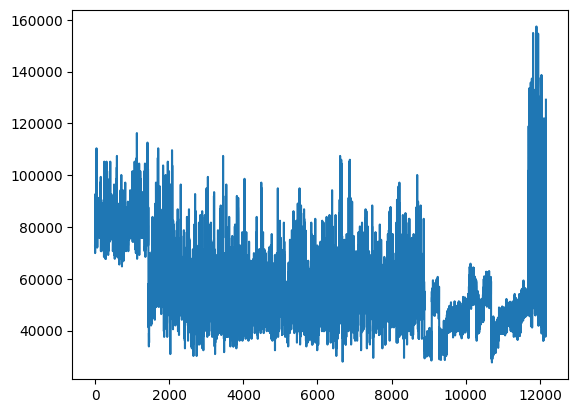

In [64]:
plt.plot(lengths)
plt.show()

In [66]:
lengths = np.sort(lengths)

In [87]:
fixed_size = lengths[int(0.85*len(lengths))]
fixed_size

75781

In [226]:
X_train, X_valid, y_train, y_valid = train_test_split(data_df.Paths.values, data_df.Emotions.values, test_size=0.2, random_state=42, shuffle=True)

In [227]:
len(X_train)

9729

In [228]:
valid_ratio = int(0.5*len(X_valid)) 
X_val, X_test = X_valid[:valid_ratio], X_valid[valid_ratio:]
y_val, y_test = y_valid[:valid_ratio], y_valid[valid_ratio:]

In [229]:
len(X_val),len(X_test)

(1216, 1217)

In [272]:
unique_emotions= data_df.Emotions.unique()
unique_emotions

array(['neutral', 'calm', 'happy', 'sad', 'angry', 'fear', 'disgust',
       'surprise'], dtype=object)

In [273]:
emotion_to_index = {emotion: index for index, emotion in enumerate(unique_emotions)}
emotion_to_index

{'neutral': 0,
 'calm': 1,
 'happy': 2,
 'sad': 3,
 'angry': 4,
 'fear': 5,
 'disgust': 6,
 'surprise': 7}

In [274]:
label_idx = emotion_to_index['angry']
new_label = tf.one_hot(label_idx,depth = len(unique_emotions))
new_label

<tf.Tensor: shape=(8,), dtype=float32, numpy=array([0., 0., 0., 0., 1., 0., 0., 0.], dtype=float32)>

In [296]:
batch_size = 32
AUTOTUNE = tf.data.experimental.AUTOTUNE
input_shape = (256, 149, 1)

In [283]:
def preprocess_data(file_path,label):
    raw_data, sr = librosa.load(file_path)
    raw_data = raw_data[:fixed_size]
    zero_padding = tf.zeros([fixed_size] - tf.shape(raw_data), dtype=tf.float32)
    raw_data = tf.concat([zero_padding, raw_data],0)
    mel_spectogram = create_mel_spectogram(np.array(raw_data),sr,plot=False)
    mel_spectogram = tf.expand_dims(mel_spectogram, axis=2)
    label_idx = emotion_to_index[label]
    new_label = tf.one_hot(label_idx,depth = len(unique_emotions))
    return mel_spectogram, new_label

In [286]:
def preprocess(X,y):
    mel_sps = []
    labels = []
    for file_path,label in zip(X,y):
        mel_sp, new_label = preprocess_data(file_path,label)
        mel_sps.append(mel_sp)
        labels.append(new_label)
    return np.array(mel_sps), np.array(labels)

In [287]:
mel_sps_train, new_labels_train = preprocess(X_train,y_train)

In [290]:
mel_sps_train.shape, new_labels_train.shape

((9729, 256, 149, 1), (9729, 8))

In [291]:
mel_sps_val, new_labels_val = preprocess(X_val,y_val)
mel_sps_test, new_labels_test = preprocess(X_test,y_test)

In [292]:
train_ds = tf.data.Dataset.from_tensor_slices((mel_sps_train,new_labels_train))
val_ds = tf.data.Dataset.from_tensor_slices((mel_sps_val,new_labels_val))
test_ds = tf.data.Dataset.from_tensor_slices((mel_sps_test,new_labels_test))

In [293]:
for x in train_ds:
    print(x)
    break

(<tf.Tensor: shape=(256, 149, 1), dtype=float32, numpy=
array([[[-80.],
        [-80.],
        [-80.],
        ...,
        [-80.],
        [-80.],
        [-80.]],

       [[-80.],
        [-80.],
        [-80.],
        ...,
        [-80.],
        [-80.],
        [-80.]],

       [[-80.],
        [-80.],
        [-80.],
        ...,
        [-80.],
        [-80.],
        [-80.]],

       ...,

       [[-80.],
        [-80.],
        [-80.],
        ...,
        [-80.],
        [-80.],
        [-80.]],

       [[-80.],
        [-80.],
        [-80.],
        ...,
        [-80.],
        [-80.],
        [-80.]],

       [[-80.],
        [-80.],
        [-80.],
        ...,
        [-80.],
        [-80.],
        [-80.]]], dtype=float32)>, <tf.Tensor: shape=(8,), dtype=float32, numpy=array([0., 0., 0., 0., 1., 0., 0., 0.], dtype=float32)>)


In [294]:
train_ds = train_ds.cache().shuffle(buffer_size=1000).batch(batch_size).prefetch(AUTOTUNE)
val_ds = val_ds.batch(batch_size).prefetch(AUTOTUNE)
test_ds = test_ds.batch(batch_size).prefetch(AUTOTUNE)

# Build Model

In [312]:
model=Sequential()
model.add(Conv2D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv2D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv2D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv2D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=8, activation='softmax'))

In [313]:
model.compile('Adam', loss='CategoricalCrossentropy', metrics=[Recall(),Precision(), Accuracy()])

In [314]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 256, 149, 256)     6656      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 75, 256)     0         
 )                                                               
                                                                 
 conv2d_5 (Conv2D)           (None, 128, 75, 256)      1638656   
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 38, 256)      0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 64, 38, 128)       819328    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 32, 19, 128)     

In [315]:
hist = model.fit(train_ds, epochs=20, validation_data=val_ds)

Epoch 1/20
305/305 [==============================] - 70s 194ms/step - loss: 3.3005 - recall_2: 0.0029 - precision_2: 0.1547 - accuracy: 0.0024 - val_loss: 1.8490 - val_recall_2: 8.2237e-04 - val_precision_2: 1.0000 - val_accuracy: 0.0000e+00
Epoch 2/20
 79/305 [======>.......................] - ETA: 42s - loss: 1.8627 - recall_2: 0.0154 - precision_2: 0.4875 - accuracy: 0.0000e+00

KeyboardInterrupt: 